# Quantum Approximate Optimization Algorithm
--------------------
This work was inspired by instruction from IBM Quantum Learning.
https://learning.quantum-computing.ibm.com/tutorial/quantum-approximate-optimization-algorithm-using-qiskit-runtime-primitives-and-sessions

## How to run the file

- Download the file.
- Open [Quantum Lab](https://quantum-computing.ibm.com/lab) and login your account.
- Upload the file on QuantumLab


## Max-Cut problem

Max-Cut problem is a graph partitioning problem that involves dividing a graph's vertices into two disjoint sets in such a way that the number of edges connecting vertices from different sets is maximized.

## Application

According to [[4]](#cite_4), the solution of Max-Cut, even if approximate, has practical application in:
- **Machine scheduling** [[1]](#cite_1)
- **Image recognition** [[2]](#cite_2) :Pairing points in two images that correspond to the same structure in the outside world.
- **Layout of electronic circuits** [[3]](#cite_4)
- **Image Segmentation**: Partition an image into distinct regions based on similarities in pixel values.

- **Community Detection in Social Networks**: Identify communities or clusters within social networks, where vertices represent individuals and edges represent relationships.

- **Traffic flow optimization**: Partition road networks to improve traffic congestion and routing.

## For users

### Adjacency matrix

In this program, users can solve the Max-Cut problem by inputting the adjacency matrix that represents the graph.

An adjacency matrix is a square matrix used to represent a finite graph. Its elements indicate whether the vertices in the graph are connected or not. In detail, when an edge exists between two vertices, the corresponding matrix element is set to 1. Conversely, if no edge connects a pair of vertices, the matrix element at that index is set to 0.

To make this concept easier to grasp, let's begin with an illustrative example.

Please run the following code by clicking on the code area and pressing `Ctrl` + `Enter`

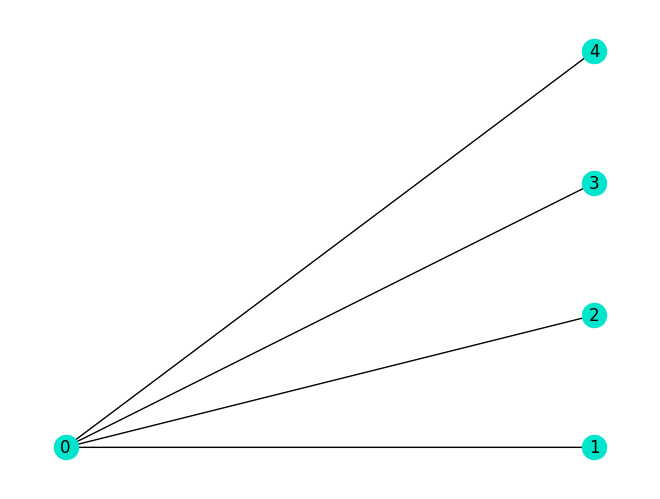

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#00e5cc")

With this graph, we can easily see that the vertex 0 is connected with the vertices 1, 2, 3, 4. So the following matrix elements will be set to `1`: {(0,1), (0,2), (0,3), (0,4), (1,0), (2,0), (3,0), (4,0)}. The other elements are set to `0`.
So the adjacency matrix of this graph will be:

In this graph, vertex 0 is connected to vertices 1, 2, 3, and 4. Therefore, the following matrix elemebts are set to '1': {(0,1), (0,2), (0,3), (0,4), (1,0), (2,0), (3,0), (4,0)}. All other elements in the adjacency matrix are set to '0'. Therefore, the adjacency matrix of this graph is as follows:

```
adjacency_matrix = [[0,1,1,1,1],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0]]
```

### Enter the adjacency matrix

To proceed, please input the `adjacency matrix` that represents the Max-Cut problem graph you would like QAOA to assist you with. 

When you are ready, press `Ctrl` + `Enter` to submit the adjacency matrix to the program.

In [2]:
adjacency_matrix = [[0, 1, 1, 1, 0],
                    [1, 0, 1, 0, 1],
                    [1, 1, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0]]

To view the result, please scroll down to the end.

## For programmers

### Setup

Let's begin by preparing the necessary tools for execution.

In [3]:
# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Sampler, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Select the simulator with the fewest number of jobs in the queue
backend = service.least_busy(simulator=True, operational=True)
backend.name

'simulator_mps'

### QAOA Hamiltonian

#### Pauli Operator
To solve the Max-Cut problem using QAOA, we need Pauli operator to encode the edges of the graph. For each edge in the graph, a Pauli-Z operator `Z` is associated with the pair of vertices that are connected by that edge. The Pauli-Z operator acts as an identity `I` on all other vertices that are not connected by the edge.

For example, for an edge connecting vertices `0` and `1`, the corresponding Pauli operator is denoted as `ZZIII`, where `Z` is applied to vertices `0` and `1`, and `I` is applied to all other vertices.

Let's construct the Pauli operator list based on the provided `adjacency_matrix` using the following code:

In [4]:
# Initialize empty lists for edges and Pauli operators
edges = []
pauli_op = []

# Define the function to construct Pauli operators based on the provided adjacency_matrix
def construct_pauli_operator(p_adjacency_matrix):
    # Compute the number of vertices in the graph
    vertex_number = len(p_adjacency_matrix)
    
    # Search for edge and construct Pauli operators
    for i in range(vertex_number):
        for j in range(i, vertex_number):
            # Check if there is an edge between vertices i and j (corresponding matrix element = 1)
            if adjacency_matrix[i][j] == 1:
                # Initialize a Pauli string with identity I for all vertices
                pauli_string = ['I'] * (vertex_number)
                
                # Assign the Pauli_Z to each vertices i and j
                pauli_string[i] = 'Z'
                pauli_string[j] = 'Z'
                
                # Form the string from the list pauli_string and append the modified pauli_string to the list pauli_op
                pauli_op.append((''.join(pauli_string),1))

# Call the construct_pauli_operator function with the adjacency_matrix
construct_pauli_operator(adjacency_matrix)

# Print the list of Pauli operators
print(pauli_op)

[('ZZIII', 1), ('ZIZII', 1), ('ZIIZI', 1), ('IZZII', 1), ('IZIIZ', 1)]


#### Construct QAOA Hamiltonian
Now, we obtain the list of Pauli operators. We then use the built-in tool `SparsePauliOp` for constructing the QAOA Hamiltonian operator. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.

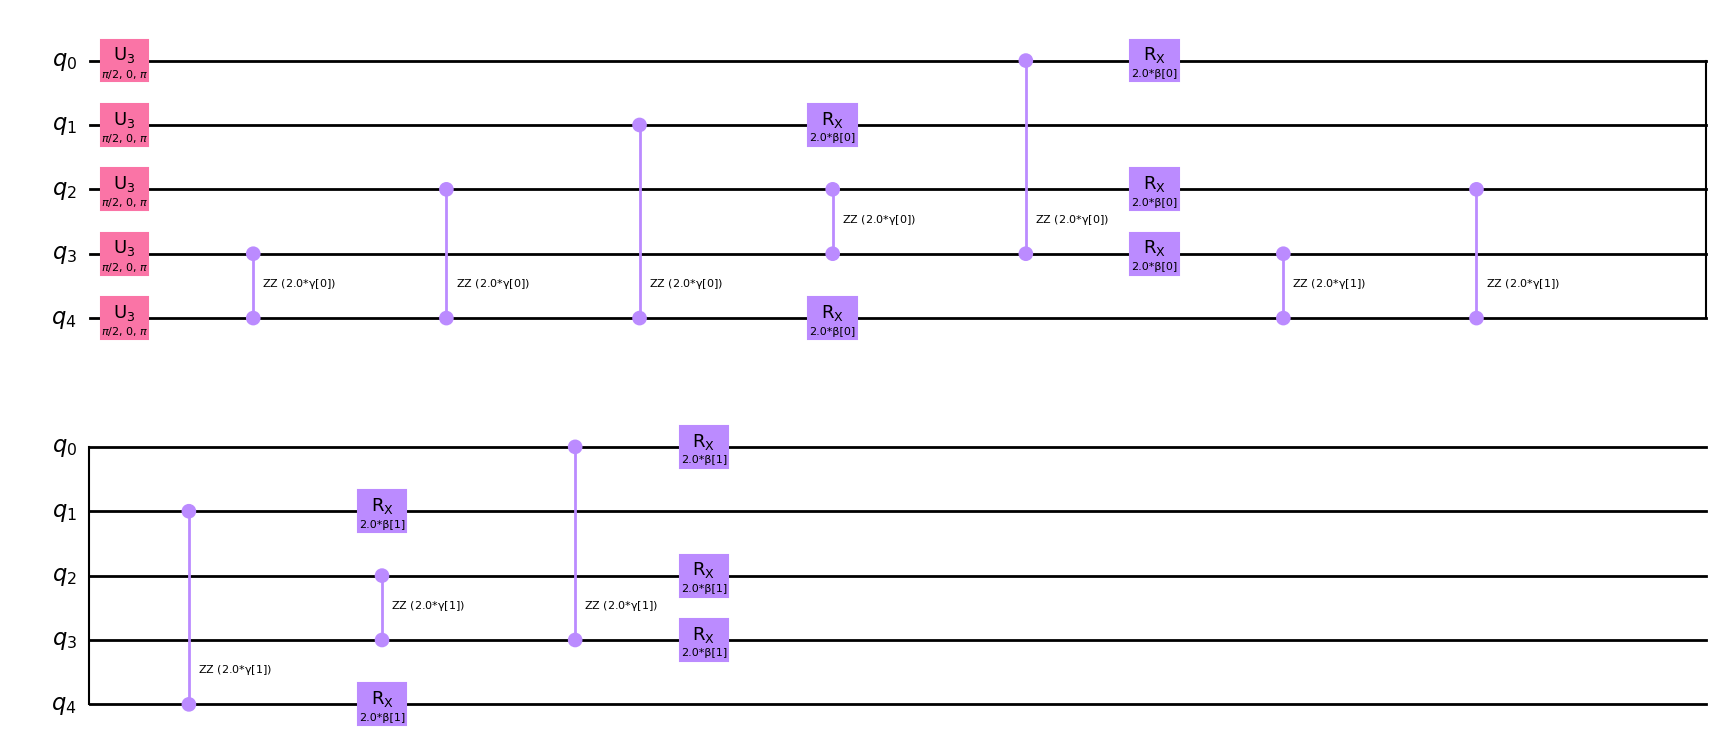

In [5]:
# Hamiltonian operator
hamiltonian = SparsePauliOp.from_list(pauli_op)

# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

# Draw
ansatz.decompose(reps=3).draw("mpl")

### Define the cost function by using Estimator

Define the cost function for minimizing it later.

The function involves computing the expectation value of the Hamiltonian with respect to the parameterized ansatz circuit using Qiskit Runtime `Estimator` primitive:

In [6]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

### Minimize the cost function

Theoretically, any classical optimizer can be used to minimize the cost function. On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better. Here, we use the COBYLA routine from SciPy.

Because we are iteratively executing many calls to Runtime, we make use of a `Session` in order to execute all calls within a single block. Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, we will need a `Sampler` primitive as well, and will instantiate it with the same `Session`.

In [7]:
# Initialize a session with the specified backend simulator
session = Session(backend=backend)

# Create an estimator and sampler for running quantum computations
estimator = Estimator(session=session, options={"shots": int(1e4)})
sampler = Sampler(session=session, options={"shots": int(1e4)})

# Set an initial set of random parameters
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

# Run our minimization routine
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator), method="COBYLA")

### Compute the solution for the Max-Cut problem

The solution vector of parameter angles `x`, when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.

In [8]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)

# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
# Close the session since we are now done with it
session.close()

## Result

The Max-Cut problem solution is visually represented in the following column chart. The tallest column in the chart corresponds to the optimal solution. To interpret the solution, refer to the values on the horizontal axis, where `0` and `1` represent the two different sets resulting from the cut. For instance, `00111` indicates that vertices `0` and `1` are in one set, while vertices `2`, `3`, and `4` belong to the other set.

Please run the following code by pressing `Ctrl` + `Enter` to see the Max-Cut problem solution.

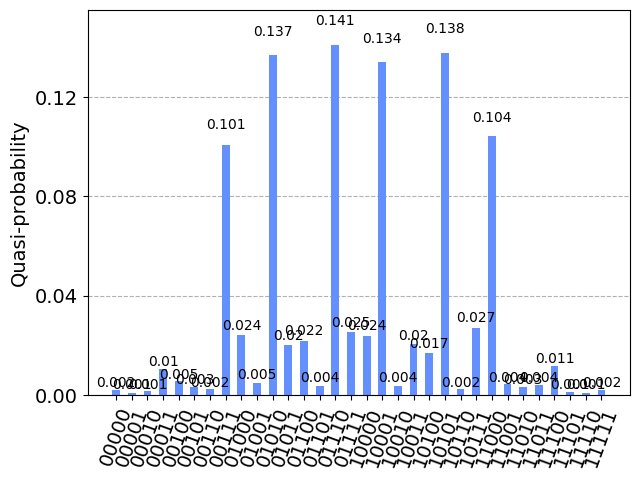

In [9]:
plot_distribution(samp_dist.binary_probabilities())

## Reference

<a id="cite_1"></a> [1] Alidaee, B., Kochenberger, G. A., & Ahmadian, A. (1994). 0-1 quadratic programming approach for optimum solutions of two scheduling problems. International Journal of Systems Science, 25(2), 401–408.

<a id="cite_2"></a> [2] Neven, H., Rose, G., & Macready, W. G. (2008). Image recognition with an adiabatic quantum computer I: Mapping to quadratic unconstrained binary optimization. arXiv:0804.4457, 1–7.

<a id="cite_3"></a> [3] Deza, M., & Laurent, M. (1994). Applications of cut polyhedra—I. Journal of Computational and Applied Mathematics, 55(2), 191-216. https://doi.org/10.1016/0377-0427(94)90020-5.

<a id="cite_4"></a> [4] Guerreschi, G. G., & Matsuura, A. Y. (2019). QAOA for Max-Cut requires hundreds of qubits for quantum speed-up. Scientific Reports, 9(1). https://arxiv.org/abs/1812.07589.